# Ranker that can takes into accound different features

# Set up

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
import sys

import dill
import lightning as L
import numpy as np
import pandas as pd
import torch
from dotenv import load_dotenv
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import MLFlowLogger
from loguru import logger
from mlflow.exceptions import MlflowException
from mlflow.models.signature import infer_signature
from pydantic import BaseModel
from torch.utils.data import DataLoader

import mlflow

load_dotenv()

sys.path.insert(0, "..")

from cfg.run_cfg import RunCfg
from src.ann import AnnIndex
from src.data_prep_utils import chunk_transform
from src.dataset import UserItemBinaryDFDataset
from src.eval.compare_runs import ModelMetricsComparisonVisualizer
from src.id_mapper import IDMapper
from src.ranker.inference import RankerInferenceWrapper
from src.ranker.model import Ranker
from src.ranker.trainer import LitRanker
from src.viz import blueq_colors

# Controller

In [3]:
max_epochs = 1

In [4]:
class Args(BaseModel):
    testing: bool = False
    author: str = "quy.dinh"
    log_to_mlflow: bool = True
    experiment_name: str = "RecSys MVP - Ranker"
    run_name: str = "038-update-compare-metrics"
    notebook_persist_dp: str = None
    random_seed: int = 41
    device: str = None

    rc: RunCfg = RunCfg().init()

    item_metadata_pipeline_fp: str = "../data/item_metadata_pipeline.dill"
    qdrant_url: str = None
    qdrant_collection_name: str = "item_desc_sbert"

    max_epochs: int = max_epochs
    batch_size: int = 128
    tfm_chunk_size: int = 10000
    neg_to_pos_ratio: int = 1

    user_col: str = "user_id"
    item_col: str = "parent_asin"
    rating_col: str = "rating"
    timestamp_col: str = "timestamp"

    top_K: int = 100
    top_k: int = 10

    embedding_dim: int = 128
    item_sequence_ts_bucket_size: int = 10
    bucket_embedding_dim: int = 16
    dropout: float = 0.3
    early_stopping_patience: int = 5
    learning_rate: float = 0.0003
    l2_reg: float = 1e-4

    mlf_item2vec_model_name: str = "item2vec"
    mlf_model_name: str = "ranker"
    min_roc_auc: float = 0.7

    best_checkpoint_path: str = None

    def init(self):
        self.notebook_persist_dp = os.path.abspath(f"data/{self.run_name}")
        os.makedirs(self.notebook_persist_dp, exist_ok=True)

        if not (qdrant_host := os.getenv("QDRANT_HOST")):
            raise Exception(f"Environment variable QDRANT_HOST is not set.")

        qdrant_port = os.getenv("QDRANT_PORT")
        self.qdrant_url = f"{qdrant_host}:{qdrant_port}"

        if not (mlflow_uri := os.environ.get("MLFLOW_TRACKING_URI")):
            logger.warning(
                f"Environment variable MLFLOW_TRACKING_URI is not set. Setting self.log_to_mlflow to false."
            )
            self.log_to_mlflow = False

        if self.log_to_mlflow:
            logger.info(
                f"Setting up MLflow experiment {self.experiment_name} - run {self.run_name}..."
            )
            self._mlf_logger = MLFlowLogger(
                experiment_name=self.experiment_name,
                run_name=self.run_name,
                tracking_uri=mlflow_uri,
                log_model=True,
            )

        if self.device is None:
            self.device = (
                "cuda"
                if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_available() else "cpu"
            )

        return self


args = Args().init()

print(args.model_dump_json(indent=2))

2024-11-16 16:57:54.399 | DEBUG    | cfg.run_cfg:init:43 - Changing use_item_tags_from_llm requires re-running notebook 002-features-v2 to get the new item_metadata_pipeline.dill file
2024-11-16 16:57:54.402 | INFO     | __main__:init:61 - Setting up MLflow experiment RecSys MVP - Ranker - run 038-update-compare-metrics...


{
  "testing": false,
  "author": "quy.dinh",
  "log_to_mlflow": true,
  "experiment_name": "RecSys MVP - Ranker",
  "run_name": "038-update-compare-metrics",
  "notebook_persist_dp": "/home/dvquys/frostmourne/recsys-mvp/notebooks/data/038-update-compare-metrics",
  "random_seed": 41,
  "device": "cuda",
  "rc": {
    "use_sbert_features": false,
    "use_item_tags_from_llm": false,
    "item_feature_cols": [
      "main_category",
      "categories",
      "price",
      "parent_asin_rating_cnt_365d",
      "parent_asin_rating_avg_prev_rating_365d",
      "parent_asin_rating_cnt_90d",
      "parent_asin_rating_avg_prev_rating_90d",
      "parent_asin_rating_cnt_30d",
      "parent_asin_rating_avg_prev_rating_30d",
      "parent_asin_rating_cnt_7d",
      "parent_asin_rating_avg_prev_rating_7d"
    ],
    "item_tags_from_llm_fp": "../data/item_tags_from_llm.parquet"
  },
  "item_metadata_pipeline_fp": "../data/item_metadata_pipeline.dill",
  "qdrant_url": "localhost:6333",
  "qdrant_co

# Implement

In [5]:
def init_model(
    n_users,
    n_items,
    embedding_dim,
    item_sequence_ts_bucket_size,
    bucket_embedding_dim,
    item_feature_size,
    dropout,
    item_embedding=None,
):
    model = Ranker(
        n_users,
        n_items,
        embedding_dim,
        item_sequence_ts_bucket_size=item_sequence_ts_bucket_size,
        bucket_embedding_dim=bucket_embedding_dim,
        item_feature_size=item_feature_size,
        dropout=dropout,
        item_embedding=item_embedding,
    )
    return model

## Load pretrained Item2Vec embeddings

In [6]:
mlf_client = mlflow.MlflowClient()
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{args.mlf_item2vec_model_name}@champion"
)
skipgram_model = model.unwrap_python_model().model
embedding_0 = skipgram_model.embeddings(torch.tensor(0))
embedding_dim = embedding_0.size()[0]
id_mapping = model.unwrap_python_model().id_mapping
pretrained_item_embedding = skipgram_model.embeddings

In [7]:
assert (
    pretrained_item_embedding.embedding_dim == args.embedding_dim
), "Mismatch pretrained item_embedding dimension"

## Load vectorized item features

In [8]:
with open(args.item_metadata_pipeline_fp, "rb") as f:
    item_metadata_pipeline = dill.load(f)

## Load ANN Index

In [9]:
if args.rc.use_sbert_features:
    ann_index = AnnIndex(args.qdrant_url, args.qdrant_collection_name)
    vector = ann_index.get_vector_by_ids([0])[0]
    sbert_embedding_dim = vector.shape[0]
    logger.info(f"{sbert_embedding_dim=}")
    neighbors = ann_index.get_neighbors_by_ids([0])
    display(neighbors)

# Prep data

In [10]:
train_df = pd.read_parquet("../data/train_features_neg_df.parquet")
val_df = pd.read_parquet("../data/val_features_neg_df.parquet")
idm_fp = "../data/idm.json"
idm = IDMapper().load(idm_fp)

assert (
    train_df[args.user_col].map(lambda s: idm.get_user_index(s))
    != train_df["user_indice"]
).sum() == 0, "Mismatch IDM"
assert (
    val_df[args.user_col].map(lambda s: idm.get_user_index(s)) != val_df["user_indice"]
).sum() == 0, "Mismatch IDM"

if args.rc.use_item_tags_from_llm:
    assert (
        "tags" in train_df.columns
    ), "There is no column `tags` in train_df, please make sure you have run notebook 002, 020 with RunCfg.use_item_tags_from_llm=True"

In [11]:
train_df

,user_id,parent_asin,rating,timestamp,timestamp_unix,parent_asin_rating_cnt_365d,parent_asin_rating_avg_prev_rating_365d,parent_asin_rating_cnt_90d,parent_asin_rating_avg_prev_rating_90d,parent_asin_rating_cnt_30d,...,user_rating_list_10_recent_asin_timestamp,item_sequence,item_sequence_ts,item_sequence_ts_bucket,tags,main_category,title,description,categories,price
0,AG57LGJFCNNQJ6P6ABQAVUKXDUDA,B0015AARJI,0.0,2016-01-12 11:59:11.000,NaN,76.0,4.592105,10.0,4.3,3.0,...,1452599936,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1452599936]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 0]","[Controller, Wireless, Gamepad, Ergonomic, Pla...",Video Games,PlayStation 3 Dualshock 3 Wireless Controller ...,"[Amazon.com, The Dualshock 3 wireless controll...","[Video Games, Legacy Systems, PlayStation Syst...",49.99
1,AHWG4EGOV5ZDKPETL56MAYGPLJRQ,B0BMGHMP23,0.0,2016-04-18 19:26:20.000,NaN,NaN,NaN,NaN,NaN,NaN,...,"1449254540,1449256005,1449257733,1452715791,14...","[3028.0, 2742.0, 2755.0, 3159.0, 3101.0, 3036....","[1449254540, 1449256005, 1449257733, 145271579...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[Wireless Mouse, Gaming Precision, High DPI, C...",Computers,Logitech G502 Lightspeed Wireless Gaming Mouse...,[G502 is the best gaming mouse from Logitech G...,"[Video Games, PC, Accessories, Gaming Mice]",87.95
2,AH5PTZ2U74OZ3HT6QVUWM4CV6OVQ,B009AP23NI,0.0,2016-02-10 18:45:08.000,NaN,9.0,4.666667,0.0,NaN,0.0,...,"1443454097,1455129080,1455129186,1455129499,14...","[-1.0, -1.0, 3234.0, 2508.0, 2318.0, 2964.0, 1...","[-1, -1, 1443454097, 1455129080, 1455129186, 1...","[-1, -1, 5, 1, 1, 0, 0, 0, 0, 0]","[Controller, Wii U, Japanese Version, Gaming A...",Video Games,Nintendo Wii U Pro U Controller (Japanese Vers...,[Wii U PRO controller (black) (WUP-A-RSKA)],"[Video Games, Legacy Systems, Nintendo Systems...",43.99
3,AFC5XTCF5D7J3NSDITB2Z26XWWYA,B001E8WQUY,5.0,2019-05-01 21:22:39.265,1.556746e+09,0.0,NaN,0.0,NaN,0.0,...,"1327120514,1377289907,1402605836,1402606396,14...","[1987.0, 4569.0, 2114.0, 1606.0, 2159.0, 2279....","[1327120514, 1377289907, 1402605836, 140260639...","[8, 8, 7, 7, 7, 7, 7, 7, 6, 6]","[Music Rhythm, Band Simulation, Multiplayer, N...",Video Games,Rock Band 2 - Nintendo Wii (Game only),"[Product description, Rock Band 2 lets you and...","[Video Games, Legacy Systems, Nintendo Systems...",28.49
4,AF7LJQOIWF3Y3YD7SGOJ34MA5JPA,B001E8WQKY,5.0,2015-01-09 12:53:25.000,1.420808e+09,16.0,4.375000,8.0,4.5,4.0,...,"1420807793,1420807991","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1, -1, -1, -1, -1, -1, -1, -1, 1420807793, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, 0, 0]","[Survival Horror, Action, Co-op, Zombies, Thir...",Video Games,Resident Evil 5 - Xbox 360,[],"[Video Games, Legacy Systems, Xbox Systems, Xb...",29.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328591,AG4RATLNVLOKZCPXN67HKOAK65CA,B078FBVJMB,0.0,2015-10-31 18:25:09.000,NaN,NaN,NaN,NaN,NaN,NaN,...,1425233294,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1425233294]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 5]","[Co-Op, Action-Adventure, Narrative, Online Mu...",Video Games,A Way Out – PC Origin [Online Game Code],[From the creators of Brothers - A Tale of Two...,"[Video Games, PC, Games]",5.99
328592,AFBXO3BFWBJX6QS5NW73O37IXF2A,B0771ZXXV6,0.0,2011-03-08 02:06:38.000,NaN,NaN,NaN,NaN,NaN,NaN,...,"1299549517,1299549928","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1, -1, -1, -1, -1, -1, -1, -1, 1299549517, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, 0, 0]","[Controller, Joy-Con, Nintendo Accessory, Wire...",Video Games,Nintendo Joy-Con (R) - Neon Red - Nintendo Switch,[To be determined],"[Video Games, Nintendo Switch, Accessories, Co...",None
328593,AHVANA5GZNJ45UABPXWZNAF4ECBQ,B00BBF6MO6,0.0,2015-02-15 05:31:04.000,NaN,3.0,4.666667,0.0,NaN,0.0,...,"1370414332,1370414707,1370416530","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 137...","

In [12]:
user_indices = train_df["user_indice"].unique()
item_indices = train_df["item_indice"].unique()
if args.rc.use_sbert_features:
    all_sbert_vectors = ann_index.get_vector_by_ids(
        item_indices.tolist(), chunk_size=1000
    ).astype(np.float32)

train_item_features = chunk_transform(
    train_df, item_metadata_pipeline, chunk_size=args.tfm_chunk_size
)
train_item_features = train_item_features.astype(np.float32)

val_item_features = chunk_transform(
    val_df, item_metadata_pipeline, chunk_size=args.tfm_chunk_size
)
val_item_features = val_item_features.astype(np.float32)

if args.rc.use_sbert_features:
    train_sbert_vectors = all_sbert_vectors[train_df["item_indice"].values]
    train_item_features = np.hstack([train_item_features, train_sbert_vectors])
    val_sbert_vectors = all_sbert_vectors[val_df["item_indice"].values]
    val_item_features = np.hstack([val_item_features, val_sbert_vectors])

logger.info(f"{len(user_indices)=:,.0f}, {len(item_indices)=:,.0f}")

Transforming chunks:   0%|          | 0/33 [00:00<?, ?it/s]

Transforming chunks:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-16 16:58:00.283 | INFO     | __main__:<module>:24 - len(user_indices)=19,578, len(item_indices)=4,630


# Train

In [13]:
rating_dataset = UserItemBinaryDFDataset(
    train_df,
    "user_indice",
    "item_indice",
    args.rating_col,
    args.timestamp_col,
    item_feature=train_item_features,
)
val_rating_dataset = UserItemBinaryDFDataset(
    val_df,
    "user_indice",
    "item_indice",
    args.rating_col,
    args.timestamp_col,
    item_feature=val_item_features,
)

train_loader = DataLoader(
    rating_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True
)
val_loader = DataLoader(
    val_rating_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False
)

In [14]:
n_items = len(item_indices)
n_users = len(user_indices)
item_feature_size = train_item_features.shape[1]

model = init_model(
    n_users,
    n_items,
    args.embedding_dim,
    args.item_sequence_ts_bucket_size,
    args.bucket_embedding_dim,
    item_feature_size,
    args.dropout,
)
model

Ranker(
  (item_embedding): Embedding(4631, 128, padding_idx=4630)
  (user_embedding): Embedding(19578, 128)
  (item_sequence_ts_bucket_embedding): Embedding(11, 16, padding_idx=10)
  (gru): GRU(144, 128, batch_first=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (item_feature_tower): Sequential(
    (0): Linear(in_features=461, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc_rating): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

#### Predict before train

In [15]:
val_df = val_rating_dataset.df
val_df.sample(10)

,user_id,parent_asin,rating,timestamp,timestamp_unix,parent_asin_rating_cnt_365d,parent_asin_rating_avg_prev_rating_365d,parent_asin_rating_cnt_90d,parent_asin_rating_avg_prev_rating_90d,parent_asin_rating_cnt_30d,...,user_rating_list_10_recent_asin_timestamp,item_sequence,item_sequence_ts,item_sequence_ts_bucket,tags,main_category,title,description,categories,price
97,AFILCGTMVK5NH4PK75F23LHWH67Q,B079FPFV3X,1.0,2022-03-08 19:15:59.095,1.646767e+09,6.0,4.166667,0.0,NaN,0.0,...,"1458314491,1458314828,1493443918,1494549215,14...","[-1, -1, -1, -1, -1, 1665, 589, 628, 3257, 98]","[-1, -1, -1, -1, -1, 1458314491, 1458314828, 1...","[-1, -1, -1, -1, -1, 8, 8, 7, 7, 7]","[Cooling Stand, Controller Charger, Vertical S...",All Electronics,OIVO PS4 Stand Cooling Fan Station for Playsta...,[],"[Video Games, PlayStation 4, Accessories, Cool...",29.99
263,AGM6YQSMWATCHIJNRZLAR6VQA3BQ,B005FMLZQQ,1.0,2021-12-18 17:59:04.227,1.639850e+09,0.0,NaN,0.0,NaN,0.0,...,"1398304794,1398304916,1398305701,1408210033,14...","[622, 2363, 1618, 1718, 1645, 1909, 1483, 1601...","[1398304794, 1398304916, 1398305701, 140821003...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 6]","[Media Accessory, Remote Control, Entertainmen...",Video Games,Xbox 360 Media Remote,"[Product Description, Control your console ent...","[Video Games, Legacy Systems, Xbox Systems, Xb...",None
385,AEM3OVK4EKZQS4LLOCCHV3DODVHQ,B01M6C7YE8,1.0,2022-04-06 22:29:42.038,1.649284e+09,2.0,5.000000,0.0,NaN,0.0,...,"1493057775,1493349602,1494506961,1494653926,14...","[3111, 4286, 3255, 1508, 94, 307, 3849, 3949, ...","[1493057775, 1493349602, 1494506961, 149465392...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]","[Open World, Action Adventure, Western, Single...",Video Games,Red Dead Redemption 2 Playstation 4,[Winner of over 175 Game of the Year Awards an...,"[Video Games, PlayStation 4, Games]",19.98
1282,AFXYMLJDPRYRC4PHVLYQVH2TXVJA,B07BLRF329,0.0,2021-12-03 20:49:24.531,NaN,1.0,5.000000,1.0,5.0,1.0,...,"1389137426,1389137541,1482821739,1482821765,15...","[-1, -1, 417, 2400, 3807, 3432, 3886, 4607, 41...","[-1, -1, 1389137426, 1389137541, 1482821739, 1...","[-1, -1, 8, 8, 7, 7, 7, 6, 6, 6]","[Action-Adventure, Exploration, Narrative Focu...",Video Games,Rise of the Tomb Raider - Xbox One Digital Code,"[Featuring epic, high-octane action moments se...","[Video Games, Xbox One, Games]",None
43,AGD2KE77JSUWQKD5CGYVGCQYJPHQ,B07TRQJ819,0.0,2021-12-13 02:24:44.720,NaN,2.0,2.000000,0.0,NaN,0.0,...,"1413412240,1417465548,1421001578,1421001632,14...","[2148, 2467, 2900, 2168, 2341, 2338, 1351, 282...","[1413412240, 1417465548, 1421001578, 142100163...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 6]","[Action RPG, Narrative-driven, Vampires, Choic...",Video Games,Vampyr - Xbox One,"[London, 1918. You are newly-turned Vampyr Dr....","[Video Games, Xbox One, Games]",16.6
918,AEK4BDRZUAXZEEPCSG3HODIY2LDA,B09C4DLF4P,1.0,2021-09-13 02:24:29.136,1.631500e+09,8.0,4.000000,2.0,4.5,0.0,...,"1498855752,1503263124,1607158037,1607714521,16...","[-1, -1, -1, -1, 3339, 2402, 4584, 4351, 4530,...","[-1, -1, -1, -1, 1498855752, 1503263124, 16071...","[-1, -1, -1, -1, 7, 7, 5, 5, 5, 3]","[Gaming Headset, Surround Sound, Lightweight, ...",Computers,Razer Kraken X Ultralight Gaming Headset: 7.1 ...,[The ultra-light Razer Kraken x is a multi-pla...,"[Video Games, PC, Accessories, Headsets]",29.99
1726,AFT6OQC26LJIJXZVFFQKYYSGWUIQ,B0083GAF12,0.0,2021-09-05 06:51:05.599,NaN,1.0,5.000000,0.0,NaN,0.0,...,"1405833312,1405833399,1405833740,1405833776,14...","[2537, 2418, 1767, 1197, 1921, 4023, 3059, 361...","[1405833312, 1405833399, 1405833740, 140583377...","[8, 8, 8, 8, 8, 8, 7, 6, 6, 5]","[Sports, Soccer, Multiplayer, Realistic Simula...",Video Games,FIFA Soccer 13 [Download],"[Amazon.com, FIFA 13, is the 2012 release in E...","[Video Games, PC]",None
1614,AFT6OQC26LJIJXZVFFQKYYSGWUIQ,B08QFPS48J,1.0,2021-09-05 06:51:05.599,1.630825e+09,29.0,3.724138,9.0,4.0,2.0,...,"1405833312,1405833399,1405833740,1405833776,14...","[2537, 2418, 1767, 1197, 1921, 4023, 3059, 36

In [16]:
user_id = val_df.sample(1)[args.user_col].values[0]
test_df = val_df.loc[lambda df: df[args.user_col].eq(user_id)]
with pd.option_context("display.max_colwidth", None):
    display(test_df)

user_id parent_asin  rating  \
1084  AH6FNJPYDJ3MTVOUIHIZGL3GTKXA  B0039LME9W     0.0   
1640  AH6FNJPYDJ3MTVOUIHIZGL3GTKXA  B0C6BV5XQZ     1.0   

                   timestamp  timestamp_unix  parent_asin_rating_cnt_365d  \
1084 2022-04-11 19:22:22.143             NaN                          0.0   
1640 2022-04-11 19:22:22.143    1.649705e+09                          1.0   

      parent_asin_rating_avg_prev_rating_365d  parent_asin_rating_cnt_90d  \
1084                                      NaN                         0.0   
1640                                      3.0                         0.0   

      parent_asin_rating_avg_prev_rating_90d  parent_asin_rating_cnt_30d  ...  \
1084                                     NaN                         0.0  ...   
1640                                     NaN                         0.0  ...   

                   user_rating_list_10_recent_asin_timestamp  \
1084  1420650289,1576447432,1585734315,1616656288,1623308629   
1640  1420650289,1576447432,1585734315,1616656288,1623308629   

                                           item_sequence  \
1084  [-1, -1, -1, -1, -1, 1267, 4196, 4373, 2511, 3386]   
1640  [-1, -1, -1, -1, -1, 1267, 4196, 4373, 2511, 3386]   

                                                                      item_sequence_ts  \
1084  [-1, -1, -1, -1, -1, 1420650289, 1576447432, 1585734315, 1616656288, 1623308629]   
1640  [-1, -1, -1, -1, -1, 1420650289, 1576447432, 1585734315, 1616656288, 1623308629]   

                  item_sequence_ts_bucket  \
1084  [-1, -1, -1, -1, -1, 8, 6, 6, 6, 5]   
1640  [-1, -1, -1, -1, -1, 8, 6, 6, 6, 5]   

                                                                               tags  \
1084  [DSi XL, Handheld Console, Bundle, Portable Gaming, Mario Kart, Retro Gaming]   
1640               [Guitar Accessory, Music Gaming, Learning Tool, Real Instrument]   

      main_category                                       title  \
1084    Video Games  Nintendo DSi XL Red Bundle with Mario Kart   
1640    Video Games                   Rocksmith Real Tone Cable   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [17]:
test_row = test_df.loc[lambda df: df[args.rating_col].gt(0)].iloc[0]
item_id = test_row[args.item_col]
item_sequence = test_row["item_sequence"]
item_sequence_ts_bucket = test_row["item_sequence_ts_bucket"]
row_idx = test_row.name
item_feature = val_item_features[row_idx]
logger.info(
    f"Test predicting before training with {args.user_col} = {user_id} and {args.item_col} = {item_id}"
)
user_indice = idm.get_user_index(user_id)
item_indice = idm.get_item_index(item_id)
user = torch.tensor([user_indice])
item_sequence = torch.tensor([item_sequence])
item_sequence_ts_bucket = torch.tensor([item_sequence_ts_bucket])
item_feature = torch.tensor([item_feature])
item = torch.tensor([item_indice])

model.eval()
model.predict(user, item_sequence, item_sequence_ts_bucket, item_feature, item)
model.train()

2024-11-16 16:58:00.461 | INFO     | __main__:<module>:7 - Test predicting before training with user_id = AH6FNJPYDJ3MTVOUIHIZGL3GTKXA and parent_asin = B0C6BV5XQZ
/tmp/ipykernel_1794229/1344924415.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  item_sequence = torch.tensor([item_sequence])


Ranker(
  (item_embedding): Embedding(4631, 128, padding_idx=4630)
  (user_embedding): Embedding(19578, 128)
  (item_sequence_ts_bucket_embedding): Embedding(11, 16, padding_idx=10)
  (gru): GRU(144, 128, batch_first=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (item_feature_tower): Sequential(
    (0): Linear(in_features=461, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc_rating): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

#### Training loop

##### Overfit 1 batch

In [18]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, mode="min", verbose=False
)

model = init_model(
    n_users,
    n_items,
    args.embedding_dim,
    args.item_sequence_ts_bucket_size,
    args.bucket_embedding_dim,
    item_feature_size,
    dropout=0,
)
lit_model = LitRanker(
    model,
    learning_rate=args.learning_rate,
    l2_reg=0.0,
    log_dir=args.notebook_persist_dp,
    accelerator=args.device,
)

log_dir = f"{args.notebook_persist_dp}/logs/overfit"

# train model
trainer = L.Trainer(
    default_root_dir=log_dir,
    accelerator=args.device if args.device else "auto",
    max_epochs=100,
    overfit_batches=1,
    callbacks=[early_stopping],
)
trainer.fit(
    model=lit_model,
    train_dataloaders=train_loader,
    val_dataloaders=train_loader,
)
logger.info(f"Logs available at {trainer.log_dir}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Ranker | 3.3 M  | train
-----------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.318    Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:251: You requested to overfit but enabled val dataloader shuffling. We are turning off the val dataloader shuffling for you.
/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:251: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not 

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.
2024-11-16 16:58:08.649 | INFO     | src.ranker.trainer:on_fit_end:171 - Logging classification metrics...
2024-11-16 16:58:26.753 | INFO     | __main__:<module>:37 - Logs available at /home/dvquys/frostmourne/recsys-mvp/notebooks/data/038-update-compare-metrics/logs/overfit/lightning_logs/version_5


In [19]:
%tensorboard --logdir $trainer.log_dir --host localhost

##### Fit on all data

In [20]:
all_items_df = train_df.drop_duplicates(subset=["item_indice"])
all_items_indices = all_items_df["item_indice"].values
all_items_features = item_metadata_pipeline.transform(all_items_df).astype(np.float32)
logger.info(
    f"Mean std over categorical and numerical features: {all_items_features.std(axis=0).mean()}"
)
if args.rc.use_sbert_features:
    all_sbert_vectors = ann_index.get_vector_by_ids(all_items_indices.tolist()).astype(
        np.float32
    )
    logger.info(f"Mean std over text features: {all_sbert_vectors.std(axis=0).mean()}")
    all_items_features = np.hstack([all_items_features, all_sbert_vectors])

2024-11-16 16:58:27.879 | INFO     | __main__:<module>:4 - Mean std over categorical and numerical features: 0.9988587498664856


In [21]:
# papermill_description=fit-model
early_stopping = EarlyStopping(
    monitor="val_loss", patience=args.early_stopping_patience, mode="min", verbose=False
)

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{args.notebook_persist_dp}/checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
)

model = init_model(
    n_users,
    n_items,
    args.embedding_dim,
    args.item_sequence_ts_bucket_size,
    args.bucket_embedding_dim,
    item_feature_size,
    dropout=args.dropout,
    item_embedding=pretrained_item_embedding,
)
lit_model = LitRanker(
    model,
    learning_rate=args.learning_rate,
    l2_reg=args.l2_reg,
    log_dir=args.notebook_persist_dp,
    evaluate_ranking=True,
    idm=idm,
    all_items_indices=all_items_indices,
    all_items_features=all_items_features,
    args=args,
    neg_to_pos_ratio=args.neg_to_pos_ratio,
    checkpoint_callback=checkpoint_callback,
    accelerator=args.device,
)

In [22]:
log_dir = f"{args.notebook_persist_dp}/logs/run"

# train model
trainer = L.Trainer(
    default_root_dir=log_dir,
    max_epochs=args.max_epochs,
    callbacks=[early_stopping, checkpoint_callback],
    accelerator=args.device if args.device else "auto",
    logger=args._mlf_logger if args.log_to_mlflow else None,
)
trainer.fit(
    model=lit_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /home/dvquys/frostmourne/recsys-mvp/notebooks/data/038-update-compare-metrics/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Ranker | 3.3 M  | train
-----------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.318    Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.
2024-11-16 16:58:49.346 | INFO     | src.ranker.trainer:on_fit_end:164 - Loading best model from /home/dvquys/frostmourne/recsys-mvp/notebooks/data/038-update-compare-metrics/checkpoints/best-checkpoint-v4.ckpt...
2024-11-16 16:58:49.513 | INFO     | src.ranker.trainer:on_fit_end:171 - Logging classification metrics...
2024-11-16 16:58:50.407 | INFO     | src.ranker.trainer:on_fit_end:174 - Logging ranking metrics...


Generating recommendations:   0%|          | 0/177 [00:00<?, ?it/s]

/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/f_beta_top_k.py:64: RuntimeWarning:

invalid value encountered in divide

2024/11/16 16:58:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 038-update-compare-metrics at: http://localhost:5002/#/experiments/3/runs/c18ad4e5fa9d47039119a9a66110ac43.
2024/11/16 16:58:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5002/#/experiments/3.


In [23]:
logger.info(
    f"Test predicting after training with {args.user_col} = {user_id} and {args.item_col} = {item_id}"
)
model.eval()
model = model.to(user.device)  # Move model back to align with data device
model.predict(user, item_sequence, item_sequence_ts_bucket, item_feature, item)
model.train()

2024-11-16 16:58:57.034 | INFO     | __main__:<module>:1 - Test predicting after training with user_id = AH6FNJPYDJ3MTVOUIHIZGL3GTKXA and parent_asin = B0C6BV5XQZ


Ranker(
  (item_embedding): Embedding(4631, 128, padding_idx=4630)
  (user_embedding): Embedding(19578, 128)
  (item_sequence_ts_bucket_embedding): Embedding(11, 16, padding_idx=10)
  (gru): GRU(144, 128, batch_first=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (item_feature_tower): Sequential(
    (0): Linear(in_features=461, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc_rating): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# Load best checkpoint

In [24]:
logger.info(f"Loading best checkpoint from {checkpoint_callback.best_model_path}...")
args.best_checkpoint_path = checkpoint_callback.best_model_path

best_trainer = LitRanker.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    model=init_model(
        n_users,
        n_items,
        args.embedding_dim,
        args.item_sequence_ts_bucket_size,
        args.bucket_embedding_dim,
        item_feature_size,
        dropout=0,
        item_embedding=pretrained_item_embedding,
    ),
)

2024-11-16 16:58:57.061 | INFO     | __main__:<module>:1 - Loading best checkpoint from /home/dvquys/frostmourne/recsys-mvp/notebooks/data/038-update-compare-metrics/checkpoints/best-checkpoint-v4.ckpt...


In [25]:
best_model = best_trainer.model.to(lit_model.device)

In [26]:
best_model.eval()
best_model.predict(user, item_sequence, item_sequence_ts_bucket, item_feature, item)
best_model.train()

Ranker(
  (item_embedding): Embedding(4631, 128, padding_idx=4630)
  (user_embedding): Embedding(19578, 128)
  (item_sequence_ts_bucket_embedding): Embedding(11, 16, padding_idx=10)
  (gru): GRU(144, 128, batch_first=True)
  (relu): ReLU()
  (dropout): Dropout(p=0, inplace=False)
  (item_feature_tower): Sequential(
    (0): Linear(in_features=461, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
  )
  (fc_rating): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Persist artifacts

In [27]:
if args.log_to_mlflow:
    # Persist id_mapping so that at inference we can predict based on item_ids (string) instead of item_index
    run_id = trainer.logger.run_id
    mlf_client = trainer.logger.experiment
    mlf_client.log_artifact(run_id, idm_fp)
    # Persist item_feature_metadata pipeline
    mlf_client.log_artifact(run_id, args.item_metadata_pipeline_fp)

    # Persist model architecture
    model_architecture_fp = f"{args.notebook_persist_dp}/model_architecture.txt"
    with open(model_architecture_fp, "w") as f:
        f.write(repr(model))
    mlf_client.log_artifact(run_id, model_architecture_fp)

### Wrap inference function and register best checkpoint as MLflow model

In [28]:
inferrer = RankerInferenceWrapper(best_model)

In [29]:
def generate_sample_item_features():
    sample_row = train_df.iloc[0].fillna(0)
    output = dict()
    for col in args.rc.item_feature_cols:
        v = sample_row[col]
        if isinstance(v, np.ndarray):
            v = "__".join(
                sample_row[col].tolist()
            )  # Workaround to avoid MLflow Got error: Per-column arrays must each be 1-dimensional
        output[col] = [v]
    return output

In [30]:
sample_input = {
    args.user_col: [idm.get_user_id(0)],
    "item_sequence": [",".join([idm.get_item_id(0), idm.get_item_id(1)])],
    "item_sequence_ts": [
        "1095133116,109770848"
    ],  # Here we input unix timestamp seconds instead of timestamp bucket because we need to calculate the bucket
    # **{col: [train_df.iloc[0].fillna(0)[col]] for col in args.item_feature_cols},
    **generate_sample_item_features(),
    args.item_col: [idm.get_item_id(0)],
}
sample_output = inferrer.infer([0], [[0, 1]], [[2, 0]], [train_item_features[0]], [0])
sample_output

array([0.74452615], dtype=float32)

In [31]:
sample_input

{'user_id': ['AE225O22SA7DLBOGOEIFL7FT5VYQ'],
 'item_sequence': ['0375869026,9625990674'],
 'item_sequence_ts': ['1095133116,109770848'],
 'main_category': ['Video Games'],
 'categories': ['Video Games__Legacy Systems__PlayStation Systems__PlayStation 3__Accessories__Controllers'],
 'price': ['49.99'],
 'parent_asin_rating_cnt_365d': [76.0],
 'parent_asin_rating_avg_prev_rating_365d': [4.592105263157895],
 'parent_asin_rating_cnt_90d': [10.0],
 'parent_asin_rating_avg_prev_rating_90d': [4.3],
 'parent_asin_rating_cnt_30d': [3.0],
 'parent_asin_rating_avg_prev_rating_30d': [5.0],
 'parent_asin_rating_cnt_7d': [1.0],
 'parent_asin_rating_avg_prev_rating_7d': [5.0],
 'parent_asin': ['0375869026']}

In [32]:
if args.log_to_mlflow:
    run_id = trainer.logger.run_id
    sample_output_np = sample_output
    signature = infer_signature(sample_input, sample_output_np)
    idm_filename = idm_fp.split("/")[-1]
    item_metadata_pipeline_filename = args.item_metadata_pipeline_fp.split("/")[-1]
    with mlflow.start_run(run_id=run_id):
        mlflow.pyfunc.log_model(
            python_model=inferrer,
            artifact_path="inferrer",
            artifacts={
                # We log the id_mapping to the predict function so that it can accept item_id and automatically convert ot item_indice for PyTorch model to use
                "idm": mlflow.get_artifact_uri(idm_filename),
                "item_metadata_pipeline": mlflow.get_artifact_uri(
                    item_metadata_pipeline_filename
                ),
            },
            model_config={"use_sbert_features": args.rc.use_sbert_features},
            signature=signature,
            input_example=sample_input,
            registered_model_name=args.mlf_model_name,
        )

/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/mlflow/models/utils.py:523: FutureWarning:

Since MLflow 2.16.0, we no longer convert dictionary input example to pandas Dataframe, and directly save it as a json object. If the model expects a pandas DataFrame input instead, please pass the pandas DataFrame as input example directly.



2024/11/16 16:58:59 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
ValueError("columns are missing: {'tags'}")Traceback (most recent call last):


  File "/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/mlflow/utils/_capture_modules.py", line 165, in load_model_and_predict
    model.predict(input_example, params=params)


  File "/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/mlflow/pyfunc/model.py", line 637, in predict
    return self.python_model.predict(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^


  File "/home/dvquys/frostmourne/recsys-mvp/notebooks/../src/ranker/inference.py", line 91, in predict
    item_features = self.item_metadata_pipeline.transform(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  File "/home/dvquys/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 903, in transform
    Xt = transfo

2024/11/16 16:59:00 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "user_id": [
      "AE225O22SA7DLBOGOEIFL7FT5VYQ"
    ],
    "item_sequence": [
      "0375869026,9625990674"
    ],
    "item_sequence_ts": [
      "1095133116,109770848"
    ],
    "main_category": [
      "Video Games"
    ],
    "categories": [
      "Video Games__Legacy Systems__PlayStation Systems__PlayStation 3__Accessories__Controllers"
    ],
    "price": [
      "49.99"
    ],
    "parent_asin_rating_cnt_365d": [
      76.0
    ],
    "parent_asin_rating_avg_prev_rating_365d": [
      4.592105263157895
    ],
    "parent_asin_rating_cnt_90d": [
      10.0
    ],
    "parent_asin_rating_avg_prev_rating_90d": [
      4.3
    ],
    "parent_asin_rating_cnt_30d": [
      3.0
    ],
    "parent_asin_rating_avg_prev_rating_30d": [
      5.0
    ],
    "parent_asin_rating_cnt_7d": [
      1.0
    ],
    "parent_asin_rating_avg_prev_rating_7d": [
      5.0
    ],
    "parent_

# Set the newly trained model as champion

2024-11-16 17:04:43.306 | INFO     | __main__:<module>:27 - Current champion model has 0.8766 ROC-AUC. Setting it to the deploy baseline...


Comparing metrics between new run and current champion:


,curr,new,diff,diff_perc
metric,,,,
val_roc_auc,0.88,0.80,-0.08,-8.61%
val_PersonalizationMetric,0.34,0.21,-0.13,-37.15%
val_FBetaTopKMetric_at_k_as_step,0.01,0.00,-0.00,-56.46%
val_loss,0.54,0.56,0.01,2.72%
val_NDCGKMetric_at_k_as_step,0.01,0.00,-0.01,-59.11%
val_precision_at_prob_as_threshold_step,96.90,92.70,-4.20,-4.33%
val_PrecisionTopKMetric_at_k_as_step,0.00,0.00,-0.00,-56.52%
val_recall_at_prob_as_threshold_step,9.70,9.30,-0.40,-4.12%
val_RecallTopKMetric_at_k_as_step,0.17,0.07,-0.09,-55.81%


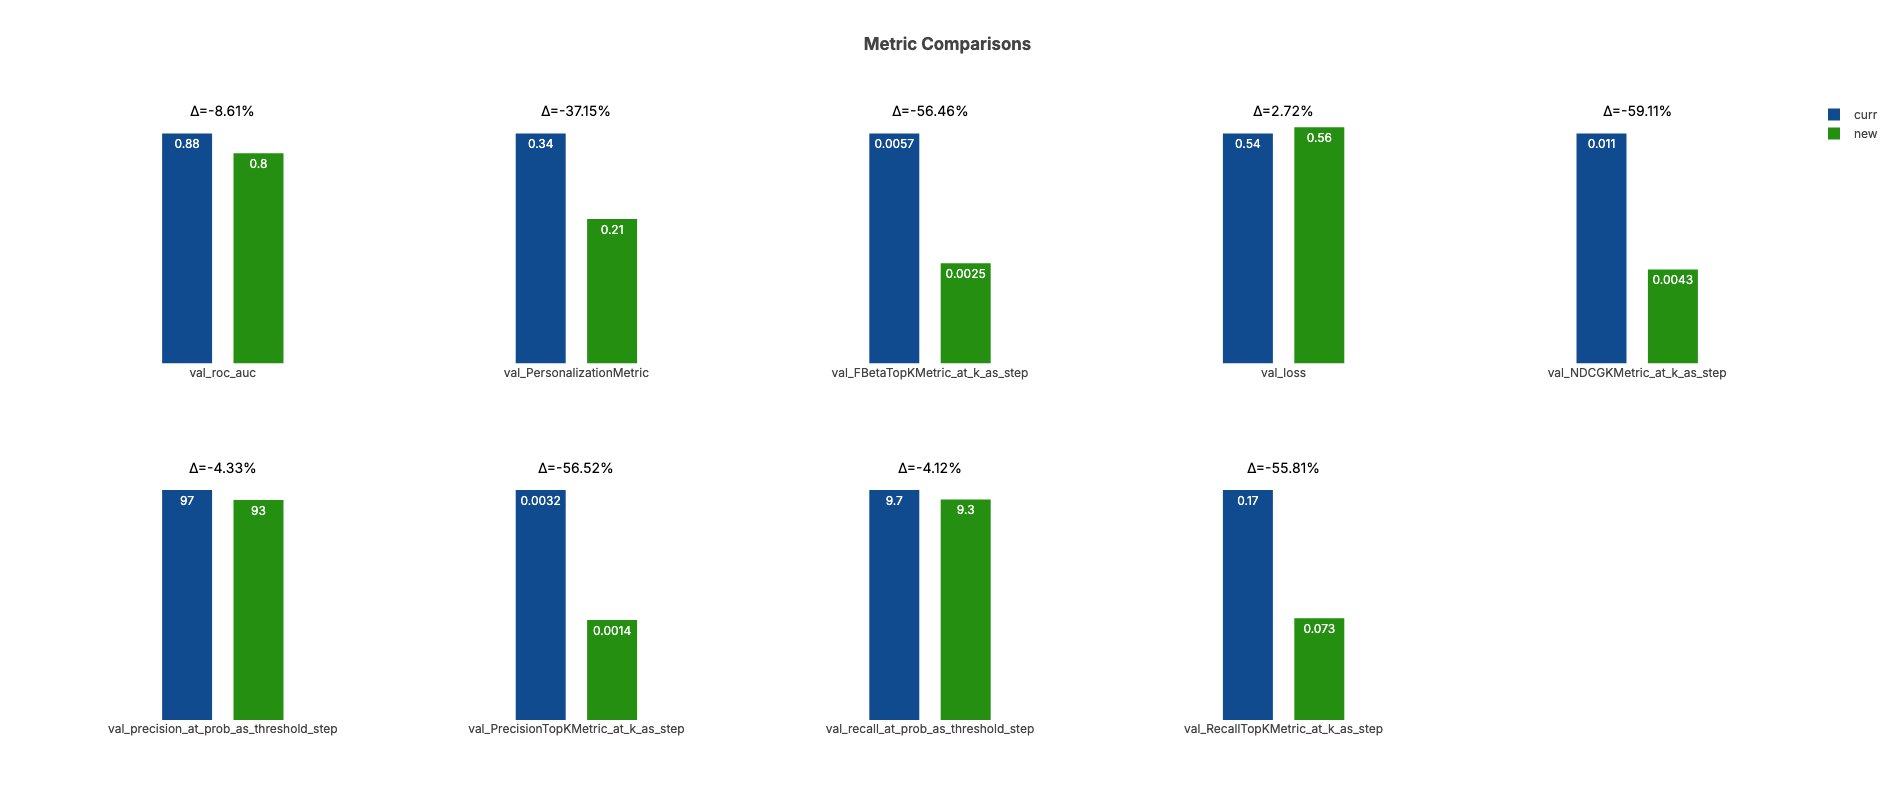

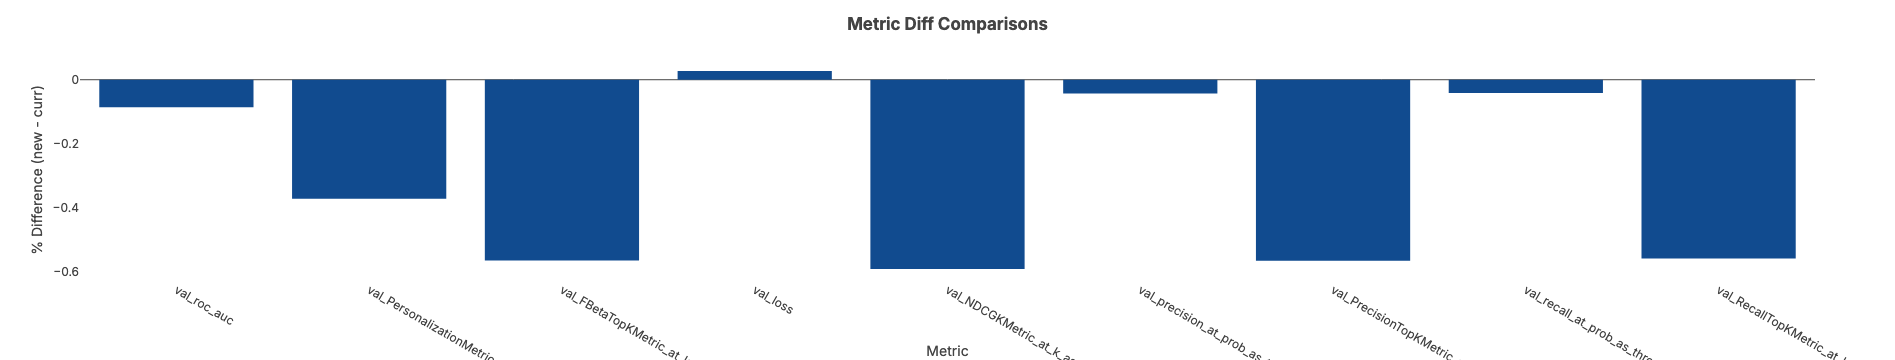

2024-11-16 17:04:43.363 | INFO     | __main__:<module>:41 - Current run has ROC-AUC = 0.8012, smaller than 0.8766. Skip aliasing this model as the new champion..


In [38]:
if args.log_to_mlflow:
    # Get current champion
    deploy_alias = "champion"
    curr_model_run_id = None

    min_roc_auc = args.min_roc_auc

    try:
        curr_champion_model = mlf_client.get_model_version_by_alias(
            args.mlf_model_name, deploy_alias
        )
        curr_model_run_id = curr_champion_model.run_id
    except MlflowException as e:
        if "not found" in str(e).lower():
            logger.info(
                f"There is no {deploy_alias} alias for model {args.mlf_model_name}"
            )

    # Compare new vs curr models
    new_mlf_run = trainer.logger.experiment.get_run(trainer.logger.run_id)
    new_metrics = new_mlf_run.data.metrics
    val_roc_auc = new_metrics["val_roc_auc"]
    if curr_model_run_id:
        curr_model_run_info = mlf_client.get_run(curr_model_run_id)
        curr_metrics = curr_model_run_info.data.metrics
        if (curr_roc_auc := curr_metrics["val_roc_auc"]) > min_roc_auc:
            logger.info(
                f"Current {deploy_alias} model has {curr_roc_auc:,.4f} ROC-AUC. Setting it to the deploy baseline..."
            )
            min_roc_auc = curr_roc_auc

        top_metrics = ["val_roc_auc", "val_PersonalizationMetric"]
        vizer = ModelMetricsComparisonVisualizer(curr_metrics, new_metrics, top_metrics)
        print(f"Comparing metrics between new run and current champion:")
        display(vizer.compare_metrics_df())
        vizer.create_metrics_comparison_plot(n_cols=5)
        vizer.plot_diff()

    # Register new champion
    if val_roc_auc < min_roc_auc:
        logger.info(
            f"Current run has ROC-AUC = {val_roc_auc:,.4f}, smaller than {min_roc_auc:,.4f}. Skip aliasing this model as the new {deploy_alias}.."
        )
    else:
        logger.info(f"Aliasing the new model as champion...")
        # Get the model version for current run by assuming it's the most recent registered version
        model_version = (
            mlf_client.get_registered_model(args.mlf_model_name)
            .latest_versions[0]
            .version
        )

        mlf_client.set_registered_model_alias(
            name=args.mlf_model_name, alias="champion", version=model_version
        )

        mlf_client.set_model_version_tag(
            name=args.mlf_model_name,
            version=model_version,
            key="author",
            value=args.author,
        )

# Clean up

In [34]:
all_params = [args]

if args.log_to_mlflow:
    with mlflow.start_run(run_id=run_id):
        for params in all_params:
            params_dict = params.dict()
            params_ = dict()
            for k, v in params_dict.items():
                if k == "top_K":
                    k = "top_big_K"
                if k == "top_k":
                    k = "top_small_k"
                params_[f"{params.__repr_name__()}.{k}"] = v
            mlflow.log_params(params_)

2024/11/16 16:59:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 038-update-compare-metrics at: http://localhost:5002/#/experiments/3/runs/c18ad4e5fa9d47039119a9a66110ac43.
2024/11/16 16:59:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5002/#/experiments/3.
